In [218]:
# Preliminary
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.special import logit, expit

In [7]:
# Global Parameters
# Number of stocks
bigN = 200
# Number of Time Periods
bigT = 100
# Number of Characteristics that underly true model
bigJ = 100

In [57]:
# Simulate the Characteristics

# rho_j ~ unif(a, b), constant across all times and stocks

# Inputs
# rho_a
# rho_b
# burn = 100, burn in period

# Outputs
# C_bar = bigN x bigJ x bigT array of characteristics
# C_bar does not have any correlation built into it, and is used as an input later
# to generate the correlated C_hat

rho_a = 0.9
rho_b = 1
burn = 100

def gen_C_bar(rho_a = 0.9, rho_b = 1, burn = 100):
    # initialze empty array, with burn in period
    C_bar = np.zeros((bigN, bigJ, bigT + burn))
    # generate rho, this is bigJ dimensional
    rho = np.random.uniform(low = rho_a, high = rho_b, size = bigJ)
    
    # interate from 1 instead of 0 here
    for t in range(1, bigT + burn):
        for j in range(0, bigJ):
            C_bar[:, j, t] = C_bar[:, j, t - 1] * rho[j] + np.random.normal(
                0, math.sqrt(1 - np.float_power(rho[j], 2)), bigN
                )
    # Get rid of burn in period
    C_bar = C_bar[:, :, burn:]

    return C_bar

In [ ]:
# Testing this out
# C_bar = gen_C_bar(rho_a = 0.9, rho_b = 1, burn = 100)

In [ ]:
# Generate Correlation Matrix

# Inputs
# lambda_degree, controls density, and therefore degree of cross sectional correlation
# Outputs
# W, bigN x bigN matrix, to build in correlation for the stock charateristics, 
# where C_hat_t = W * C_bar_t

lambda_degree = 0.01

def gen_W(bigN, lambda_degree):
    # 
    Lambda = np.random.normal(
        0, lambda_degree, size = (bigN, bigN)
    )
    # Use Lambda to create B matrix
    B = np.matmul(Lambda, Lambda.T)
    B = B + 0.1 * np.eye(bigN)
    # Create W matrix via cholesky to give the lower triangle matrix
    W = np.linalg.cholesky(B)

    return W


In [83]:
# Generate C_hat
def gen_C_hat(C_bar, lambda_degree):
    bigN = C_bar.shape[0]
    bigT = C_bar.shape[2]
    W = gen_W(bigN, lambda_degree)

    C_hat = np.zeros(C_bar.shape)
    for t in range(0, bigT):
        C_hat[:, :, t] = np.matmul(W, C_bar[:, :, t])

    return C_hat


In [149]:
# Generate the observed characteristics
# This "observes" the characteristics by normalizing them to
# (-1, 1) via a rank transformation

def gen_C(C_hat):
    C_mat = np.zeros(C_hat.shape)
    bigN = C_hat.shape[0]
    bigJ = C_hat.shape[1]
    bigT = C_hat.shape[2]

    for t in range(0, bigT):
        for i in range(0, bigN):
            C_mat[i, :, t] = (2 / (bigJ + 1)) * C_hat[i, :, t].argsort().argsort() - 1
    # double argsort is a rank transformation
    # https://www.berkayantmen.com/rank

    return C_mat

In [150]:
C_bar = gen_C_bar(rho_a = 0.9, rho_b = 1, burn = 100)
C_hat = gen_C_hat(C_bar, lambda_degree)
C = gen_C(C_hat)

In [196]:
# Generate the actual stock returns

# Specify VAR coefficients
A1 = 0.95 * np.eye(3)
A2 = np.array([
    [0.74, 0, 0.25],
    [0, 0.95, 0], 
    [0.25, 0, 0.74]
])
A3 = np.array([
    [0.95, 0.04, 0.01], 
    [0.04, 0.9, -0.3], 
    [0.01, -0.3, -0.95]
])

# check that roots lie outside the unit circle
# equiv to checking that eigenvalues are INSIDE the unit circle
print(np.linalg.eigvals(A1))
print(np.linalg.eigvals(A2))
print(np.linalg.eigvals(A3))

def gen_xt(A, bigT, burn):
    xt = np.zeros((3, bigT + burn))
    ut = np.random.normal(0, math.sqrt(1 - (0.95)**2), (3, bigT + burn))

    for t in range(1, bigT + burn):
        xt[:, t] = np.matmul(A, xt[:, t - 1]) + ut[:, t]
    
    # get rid of burn in 
    xt = xt[:, burn:]
    return xt


[0.95 0.95 0.95]
[0.99 0.49 0.95]
[ 0.98675328  0.91081278 -0.99756606]


0.01
0.01
0.1


/tmp/ipykernel_1496874/20333944.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_1 = sm.tsa.stattools.kpss(xt[0, :], regression = "c")
/tmp/ipykernel_1496874/20333944.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_2 = sm.tsa.stattools.kpss(xt[1, :], regression = "c")
/tmp/ipykernel_1496874/20333944.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_3 = sm.tsa.stattools.kpss(xt[2, :], regression = "c")


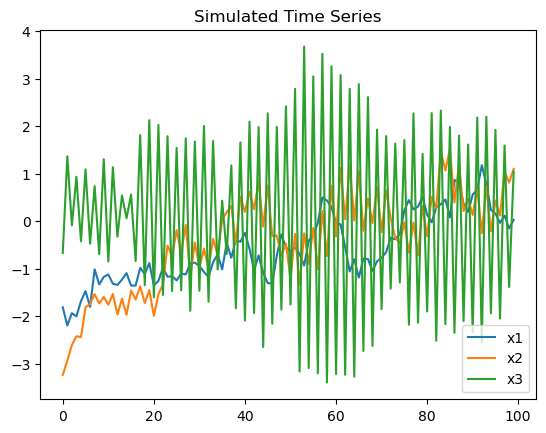

In [197]:
xt = gen_xt(A3, bigT, burn)

# plot the three series as a visual check
plt.plot(xt[0, :], label = "x1")
plt.plot(xt[1, :], label = "x2")
plt.plot(xt[2, :], label = "x3")
plt.legend(loc = "lower right")
plt.title("Simulated Time Series")

# Some Unit Root Tests
# KPSS tests null that the series is stationary
kpss_1 = sm.tsa.stattools.kpss(xt[0, :], regression = "c")
kpss_2 = sm.tsa.stattools.kpss(xt[1, :], regression = "c")
kpss_3 = sm.tsa.stattools.kpss(xt[2, :], regression = "c")

print(kpss_1[1])
print(kpss_2[1])
print(kpss_3[1])

In [228]:
# Generate the factors for the entire panel

# Only 3 of the characteristics are used to generate the factors

# Inputs
# xt, 3 x bigT array of macroeconomic indicators
# C, bigN x bigJ x bigT array of stock characteristics
# Outputs
# G, bigN x 3 x bigT array of stock factors

# G1 case
def gen_G_factors(xt, C, G_func):
    bigN = C.shape[0]
    bigT = C.shape[2]

    G = np.zeros((bigN, 3, bigT))

    if G_func == "G1":
        for t in range(0, bigT):
            for i in range(0, bigN):
                G[i, :, t] = np.array([
                    C[i, 0, t], C[i, 1, t], C[i, 2, t] * xt[2, t]
                ])
    elif G_func == "G2":
        for t in range(0, bigT):
            for i in range(0, bigN):
                G[i, :, t] = np.array([
                    C[i, 0, t]**2, C[i, 0, t] * C[i, 1, t], np.sign(C[i, 2, t] * xt[2, t])
                ])
    elif G_func == "G3":
        for t in range(0, bigT):
            for i in range(0, bigN):
                np.array([
                    C[i, 2, t] > 1, 
                    C[i, 1, t]**3, 
                    C[i, 0, t] * C[i, 1, t] * (C[i, 2, t] > 0), 
                    logit(C[i, 2, t])
                    ])
    
    return G



In [229]:
# gen_G
# Inputs
# G_factors, bigN x 3 x bigT array of stock factors
# theta, 3 x 1 array of "factor loadings"
# Outputs
# G = bigN x bigT array of stock factors

def gen_G(G_factors, theta):
    bigN = G_factors.shape[0]
    bigT = G_factors.shape[2]

    G = np.zeros((bigN, bigT))
    
    for t in range(0, bigT):
        G[:, t] = np.matmul(G_factors[:, :, t], theta)

    return G

In [273]:
# Error Generation
omega = -0.736
gamma = 0.90
w = math.sqrt(0.363)
ep_sd = 0.05
sv = 1
v_sd = 0.05

# gen_error
# The error is actually a composite of two components
# beta_v, which is the stock specific component
# and e_it, which is pure noise that has SV

# Inputs
# sv = logical, whether to turn on stochastic volatility
# ep_sd, normal sd in sv case, student t sd in simple case
# omega
# gamma
# w
# C, bigN x bigJ x bigT array of stock characteristics
# v_sd
# Outputs
# e_mat, bigN x bigT array of errors

def gen_error(sv, ep_sd, omega, gamma, w, C, v_sd, burn = 100):
    # Preliminary
    bigN = C.shape[0]
    bigT = C.shape[2]
    
    # beta_v component
    beta = C[:, 0:3, :]
    beta_v = np.zeros((bigN, bigT))
    v = np.random.normal(0, v_sd, (3, bigT))

    for t in range(0, bigT):
        for i in range(0, bigN):
            beta_v[i, t] = np.matmul(beta[i, :, t], v[:, t])

    # e_it component, which has possible SV
    e_mat = np.zeros((bigN, bigT + burn))
    if sv == 1:
        # Stochastic Volatility Case
        logsigma2 = np.zeros((1, bigT + burn))
        # initialize at long run mean
        logsigma2[0, 0] = omega / (1 - gamma)
        for t in range(1, bigT + burn):
            logsigma2[0, t] = omega + gamma * logsigma2[0, t - 1] + w * np.random.normal(0, 1)
            for i in range(0, bigN):
                e_mat[i, t] = math.sqrt(math.exp(logsigma2[0, t])) * np.random.normal(0, ep_sd)
    else: 
        # Student t error case
        for t in range(0, bigT + burn):
            for i in range(0, bigN):
                e_mat[:, t] = np.random.standard_t(df = 5, size = bigN) * math.sqrt(ep_sd**2 * (5 - 2)/5)

    # get rid of burn in period
    e_mat = e_mat[:, burn:]
    # return the sum of the two components
    return beta_v + e_mat

Text(0.5, 1.0, 'Simulated Error Series')

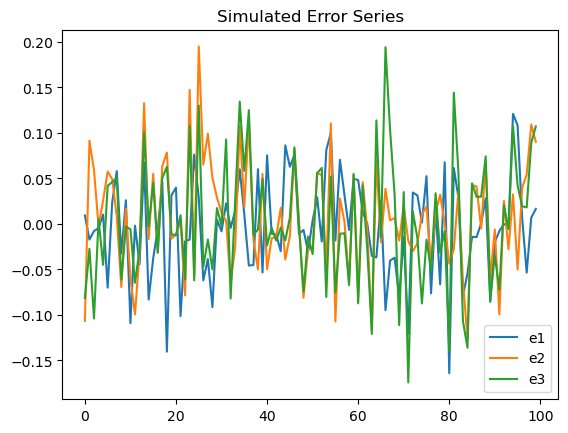

In [275]:
e_mat = gen_error(
    sv = 1, ep_sd = ep_sd, 
    omega = omega, gamma = gamma, w = w, 
    C = C, v_sd = v_sd, burn = 100)
e_mat.shape
# visually check
plt.plot(e_mat[0, :], label = "e1")
plt.plot(e_mat[1, :], label = "e2")
plt.plot(e_mat[2, :], label = "e3")
plt.legend(loc = "lower right")
plt.title("Simulated Error Series")

In [ ]:
# Helper functions to calculate the Rsquared, as defined by the Finance literature
# Time series R-squared
# 1. R_it = alpha_i + beta_i * factor_t + e_it
# 2. Save the coefficients beta for this, and label them as lambda
# 3. Calculate the SSR and SST, and hence R squared from each of these





0.03872983346207417

In [ ]:
# Cross sectional R-squared
# Essentially run a cross sectioonal regression of average returns on the estimated betas 
# from before
# See Cochrane 2005 for more details
# 1. E(R_ei) = alpha_1 + b_i * lambda

In [219]:
i = 1
t = 1
print(C[i, 2, t])
np.array([
    C[i, 2, t] > 1, 
    C[i, 1, t]**3, 
    C[i, 0, t] * C[i, 1, t] * (C[i, 2, t] > 0), 
    logit(C[i, 2, t])
    ])

0.3465346534653466


array([ 0.        , -0.83215973,  0.71708656, -0.63430668])

In [148]:
# C_hat = gen_C_hat(C_bar, lambda_degree)
# C_mat = gen_C(C_hat)

test = (2 / (bigJ + 1)) * (C_hat[1, :, 1].argsort().argsort()) - 1
print(np.max(test))
print(np.min(test))

0.9603960396039604
-1.0
